In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/car-object-detection


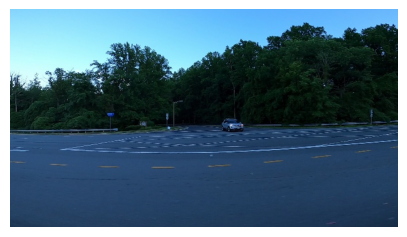

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
# Display first image
image = Image.open(path + "/data/training_images/vid_4_980.jpg")
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

In [3]:
import pandas as pd
df = pd.read_csv(path + "/data/train_solution_bounding_boxes (1).csv")
# image = name, xmin = bounding box xmin coord, ymin = bounding box ymin coord,
# xmax = bounding box xmax coord, ymax = bounding box ymax coord
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


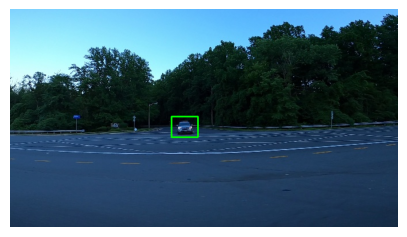

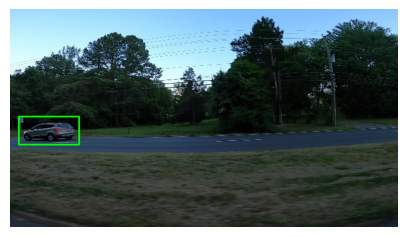

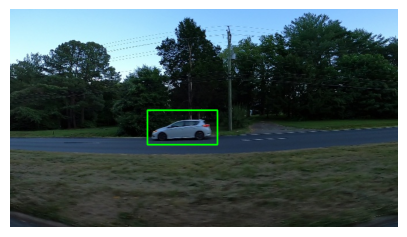

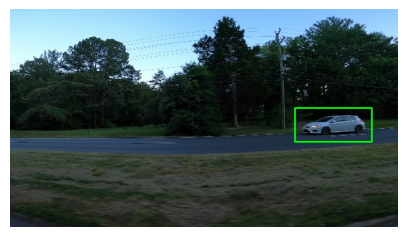

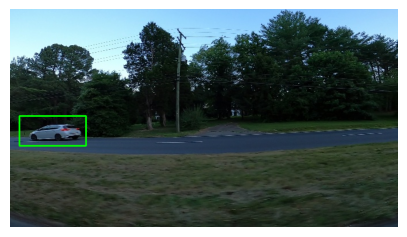

In [4]:
import cv2

# preview first 5 images in df with bounding boxes
for i in range(5):
    # get current row
    row = df.iloc[i]
    
    # obtain row values for image
    name = row["image"]

    # convert coordinates to ints to represent pixels
    xmin = int(row["xmin"])
    ymin = int(row["ymin"])
    xmax = int(row["xmax"])
    ymax = int(row["ymax"])
    
    # read image
    image = cv2.imread("/kaggle/input/car-object-detection/data/training_images/" + name)

    # draw rectangle to represent bounding box
    # (image, start point, end point, color, thickness)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # convert to rgb
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # display the image
    plt.figure(figsize=(5,5))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

In [5]:
# make directories for YOLO data structure
import os
# make new directory to store data because kaggle dataset is read-only
os.makedirs("/kaggle/working/dataset", exist_ok=True)
for ext_dir in ["images", "labels"]:
  for int_dir in ["train", "val", "test"]:
    # os.path.join combines the file paths safely
    # exist_ok allows the path to be made even if it already exists
    os.makedirs(os.path.join("/kaggle/working/dataset", ext_dir, int_dir), exist_ok=True)

In [6]:
import shutil
# define function that takes each image in the training/validation set and
# 1. copies the image into its proper directory
# 2. calculates the center_x, center_y, width, and height of the bounding box
# 3. creates a text file containing these values and stores them in their proper directory
def get_annotation(df, folder):
  for idx, row in df.iterrows():
    # extract name, xmin, ymin, xmax, ymax from each image with a bounding box
    name = row["image"]
    xmin = row["xmin"]
    ymin = row["ymin"]
    xmax = row["xmax"]
    ymax = row["ymax"]

    # calculate center_x, center_y, width, and height
    width = xmax - xmin
    height = ymax - ymin
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    # get image size
    with Image.open(os.path.join("/kaggle/input/car-object-detection/data/training_images", name)) as img:
      img_width, img_height = img.size

    # normalize data values
    width /= img_width
    height /= img_height
    center_x /= img_width
    center_y /= img_height

    # copy image to working dataset
    # shutil.copy copies a file from a source path to destination path
    shutil.copy(os.path.join("/kaggle/input/car-object-detection/data/training_images", name),
                os.path.join("/kaggle/working/dataset/images", folder, name))

    # create label .txt file for image
    # os.path.splittext splits a file with its root path and the extension
    # we use it to get the root name of the image (without its extension .jpg)
    # and add the .txt extension
    filepath = os.path.join("/kaggle/working/dataset/labels", folder, os.path.splitext(name)[0] + ".txt")

    # write to file
    with open(filepath, "w") as f:
      f.write(f"{0} {center_x} {center_y} {width} {height}")

In [7]:
from sklearn.model_selection import train_test_split
# split randomized dataset into training and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# perform annotation on both datasets
get_annotation(train_df, "train")
get_annotation(val_df, "val")

In [8]:
# copy test images to working dataset to be evaluated by model
# after training
test_imgs = os.listdir("/kaggle/input/car-object-detection/data/testing_images")
for img in test_imgs:
  shutil.copy("/kaggle/input/car-object-detection/data/testing_images/" + img, "/kaggle/working/dataset/images/test/" + img)

In [9]:
# create yaml file to be passed to YOLO model
data = f"""
path: /kaggle/working/dataset

# training images
train: ../images/train

# validation images
val: ../images/val

# test images
test: ../images/test

# number of classes
nc: 1

# names of classes
names: ["car"]
"""

# create data.yaml file in working dataset and write to it
with open("data.yaml", "w") as f:
  f.write(data)

In [10]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [11]:
from ultralytics import YOLO
# load yolov11 pre-trained model
model = YOLO("yolo11n.pt")

# train the model on the data
train_results = model.train(data="data.yaml",
                            epochs=50,
                            imgsz=650,
                            batch=16,
                            name="car_detection_model",
                            device="cuda"
                            )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 95.6MB/s]


Ultralytics 8.3.107 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=650, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=car_detection_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

100%|██████████| 755k/755k [00:00<00:00, 24.3MB/s]
E0000 00:00:1744602873.304961      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744602873.358754      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/dataset/labels/train... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 1452.86it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/dataset/labels/val... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 1882.51it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/car_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 672 train, 672 val
Using 4 dataloader workers
Logging results to runs/detect/car_detection_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.45G      1.556      3.272      1.151          5        672: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


                   all         94         94    0.00333          1      0.503      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.45G      1.368      2.226      1.172          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         94         94    0.00326      0.979     0.0878     0.0307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.46G      1.313       1.97      1.127          9        672: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         94         94      0.635     0.0928      0.439      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.46G      1.265      1.829      1.138          7        672: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all         94         94      0.645      0.489      0.593      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.46G      1.319      1.762       1.15          5        672: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         94         94      0.545      0.649       0.57      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.46G      1.319      1.707      1.165          7        672: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         94         94      0.537      0.713       0.56      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.46G      1.278      1.612      1.167          5        672: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         94         94      0.517      0.787      0.578      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.46G      1.239      1.561      1.157          1        672: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         94         94      0.531      0.819      0.568      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.46G      1.277      1.444      1.154          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         94         94      0.506      0.883      0.596      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.46G      1.282      1.394      1.146          7        672: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         94         94      0.514      0.926      0.617      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.46G      1.202       1.21      1.117          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         94         94        0.6      0.766      0.651      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.46G      1.245      1.242      1.128          4        672: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         94         94      0.569      0.851      0.645      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.46G      1.198      1.183      1.097          7        672: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         94         94      0.535      0.808      0.609      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.46G      1.263        1.2      1.128          4        672: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

                   all         94         94      0.512      0.904      0.614      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.46G      1.185      1.152       1.09          8        672: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         94         94      0.494      0.915      0.608      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.46G      1.139      1.085      1.102          4        672: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         94         94      0.532      0.799      0.635      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.46G      1.148       1.08      1.086          5        672: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         94         94      0.523       0.84      0.626      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.46G      1.119      1.004       1.06          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         94         94      0.571      0.751      0.647      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.46G      1.146      1.004      1.063          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         94         94       0.61      0.798      0.683      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.46G      1.184      1.011       1.08          5        672: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]

                   all         94         94      0.522      0.915      0.729      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.46G      1.207      1.035      1.086          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]

                   all         94         94      0.523      0.936      0.717      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.46G       1.13     0.9723      1.076          7        672: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         94         94      0.558      0.894       0.68      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.46G      1.071     0.8895      1.052          4        672: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]

                   all         94         94       0.58      0.822      0.665      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.46G      1.151     0.9527      1.061          5        672: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         94         94      0.551      0.851      0.622      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.46G      1.092     0.9179      1.061          4        672: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

                   all         94         94      0.561      0.915      0.678      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.46G      1.067     0.8891      1.048          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         94         94      0.524       0.84      0.714      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.46G      1.055     0.8596      1.024          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

                   all         94         94      0.516      0.894      0.734      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.46G      1.089     0.9013      1.038          8        672: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

                   all         94         94      0.527       0.84      0.701       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.46G      1.095     0.8625       1.03          8        672: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         94         94      0.578       0.84       0.73      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.46G      1.073     0.8692      1.022          5        672: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         94         94      0.524       0.83      0.666      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.46G      1.037     0.8332      1.023          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         94         94      0.514       0.83      0.681      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.46G       1.05     0.8792      1.031          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         94         94      0.536       0.84      0.689      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.46G      1.058      0.825      1.024          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         94         94      0.534       0.84      0.665       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.46G      1.078     0.8448       1.05          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

                   all         94         94      0.528      0.851      0.701       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.46G      1.063     0.8423      1.027          4        672: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         94         94      0.484      0.904      0.698      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.46G      1.065     0.8112       1.04          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

                   all         94         94      0.542      0.755      0.695       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.46G      1.022     0.8346     0.9975          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

                   all         94         94      0.477      0.862       0.69      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.46G      1.012     0.8063      1.009          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]

                   all         94         94      0.506      0.873      0.698      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.46G      0.988     0.7869      1.005          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]

                   all         94         94      0.491      0.904       0.69       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.46G     0.9896     0.7895      0.998          6        672: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         94         94      0.515      0.894      0.692      0.465


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.54G     0.9678     0.7645          1          3        672: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.80it/s]

                   all         94         94      0.492      0.809      0.681      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.54G      1.001      0.794      1.019          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

                   all         94         94      0.502      0.862      0.667      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.54G     0.9839     0.7843       1.01          2        672: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         94         94      0.482      0.872      0.638      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.54G      1.015     0.7851      1.004          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.80it/s]

                   all         94         94      0.505      0.755      0.651      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.54G     0.9489     0.7215      1.005          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

                   all         94         94      0.456      0.798      0.648      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.54G     0.9134     0.7084     0.9846          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

                   all         94         94       0.57      0.574      0.657      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.54G     0.9247     0.6785      1.002          2        672: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]

                   all         94         94      0.483      0.777       0.66      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.54G     0.9084     0.6835     0.9744          2        672: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         94         94      0.496      0.798      0.655      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.54G      0.922     0.6881     0.9767          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]

                   all         94         94      0.492      0.784      0.648      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.54G     0.8961     0.6672     0.9684          3        672: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         94         94      0.498      0.759      0.644      0.433



50 epochs completed in 0.065 hours.
Optimizer stripped from runs/detect/car_detection_model/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/car_detection_model/weights/best.pt, 5.5MB

Validating runs/detect/car_detection_model/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


                   all         94         94      0.516      0.894      0.734      0.504


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/car_detection_model


In [12]:
metrics = model.val()

Ultralytics 8.3.107 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/dataset/labels/val.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


                   all         94         94      0.516      0.894      0.734      0.499


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.3ms preprocess, 5.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/car_detection_model2



image 1/1 /kaggle/working/dataset/images/test/vid_5_31120.jpg: 384x672 2 cars, 41.9ms
Speed: 2.0ms preprocess, 41.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 672)


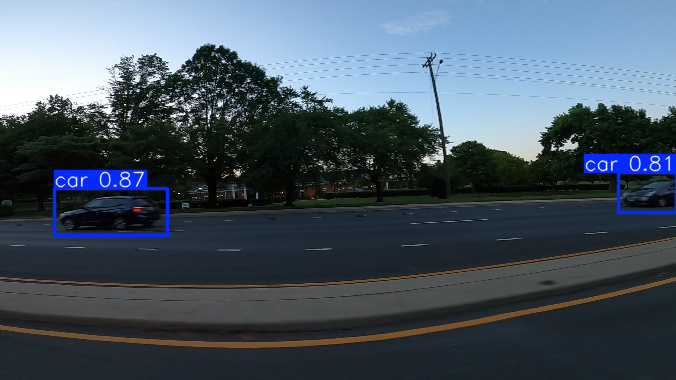


image 1/1 /kaggle/working/dataset/images/test/vid_5_26740.jpg: 384x672 3 cars, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 672)


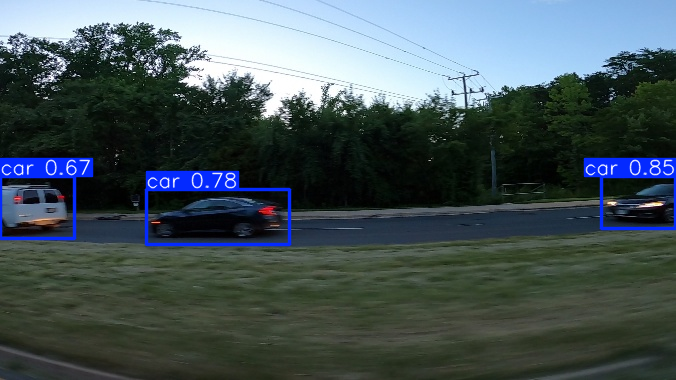


image 1/1 /kaggle/working/dataset/images/test/vid_5_30920.jpg: 384x672 1 car, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 672)


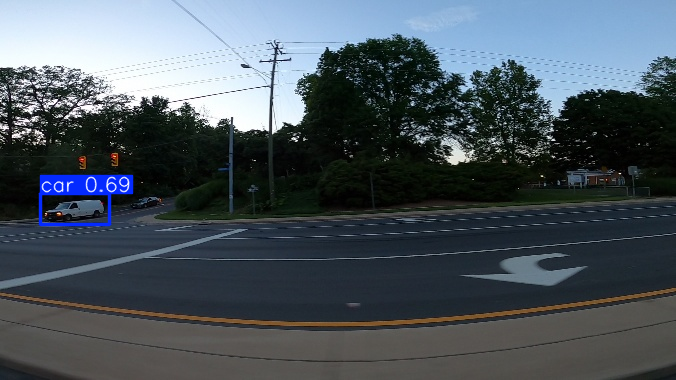


image 1/1 /kaggle/working/dataset/images/test/vid_5_30160.jpg: 384x672 1 car, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 672)


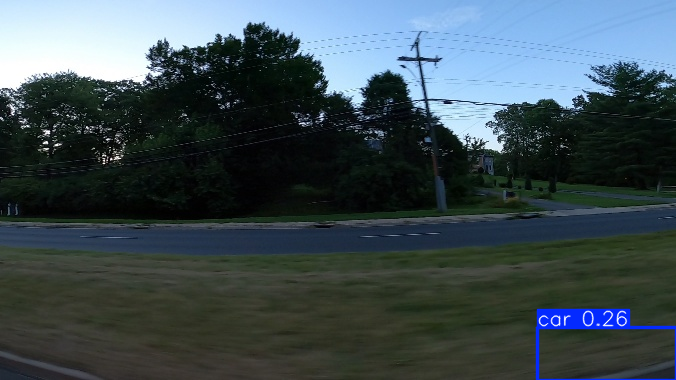


image 1/1 /kaggle/working/dataset/images/test/vid_5_29900.jpg: 384x672 (no detections), 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 672)


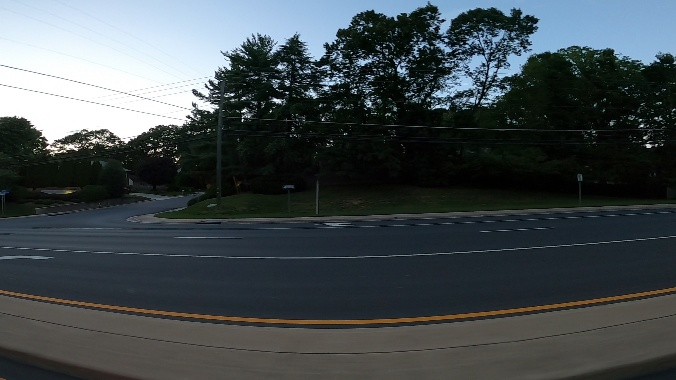

In [13]:
import random

# sample random 5 images in test set to see how model performed
imgs = random.sample(os.listdir('/kaggle/working/dataset/images/test/'), 5)

for img in imgs:
    preds = model('/kaggle/working/dataset/images/test/' + img) # predict on an image
    preds[0].show() # display results